<a id='0'></a>
# <p style="background-color:lightgray; font-family:newtimeroman; font-weight: 700; font-size:300%; text-align:center; border-radius: 50px 50px;">Text classification with SciBERT </p>

Reference :

SciBERT : https://arxiv.org/pdf/1903.10676v3.pdf

In [1]:
!pip install transformers
!pip install torchtext==0.9.0
!pip install numpy requests nlpaug
!pip install torch>=1.8.0 fairseq>=0.9.0 sacremoses>=0.0.43 fastBPE>=0.1.0

     |████████████████████████████████| 7.1 MB 4.5 MB/s 
     |████████████████████████████████| 735.5 MB 7.3 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.7.0
    Uninstalling torch-1.7.0:
      Successfully uninstalled torch-1.7.0
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.8.0a0+cd6902d
    Uninstalling torchtext-0.8.0a0+cd6902d:
      Successfully uninstalled torchtext-0.8.0a0+cd6902d
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 2.3.0 requires torch<1.8,>=1.7.0, but you have torch 1.8.0 which is incompatible.
     |████████████████████████████████| 394 kB 4.3 MB/s 


In [2]:
data_path = '../input/math80600aw21/'
output_path = './'

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

#data augmentation
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas
import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import torch
from torch.utils.data import random_split
from torchtext.legacy.data import Field, TabularDataset, BucketIterator, Iterator
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup

import warnings
warnings.filterwarnings('ignore')

import logging
logging.getLogger("transformers.tokenization_utils_base").setLevel(logging.ERROR)

In [4]:
#create dataframe
trainurl = f"{data_path}train.csv"
testurl = f"{data_path}test.csv"
nodeid2paperidurl = f"{data_path}nodeid2paperid.csv"
texturl = f"{data_path}text.csv"
sampleurl = f"{data_path}sample.csv"
train_df = pd.read_csv(trainurl,names=['label', 'node idx'])
test_df = pd.read_csv(testurl,names=['node idx'])
nodeid2paperid_df = pd.read_csv(nodeid2paperidurl)
text_df = pd.read_csv(texturl, names=['paper id', 'title', 'abstract'])
sample_df = pd.read_csv(sampleurl)

In [5]:
#merge dataframe
# test
test = pd.merge(nodeid2paperid_df ,text_df,  how = 'left', on = 'paper id')
test_merged = pd.merge(test_df,test,  how = 'left', on = 'node idx')
#test_merged.drop(['paper id',"abstract"], axis=1,inplace=True)
test_merged.drop(['paper id'], axis=1,inplace=True)

# train
train = pd.merge(nodeid2paperid_df ,text_df,  how = 'left', on = 'paper id')
train_merged = pd.merge(train_df,train,  how = 'left', on = 'node idx')
#train_merged.drop(['node idx',"abstract",'paper id'], axis=1,inplace=True)
train_merged.drop(['node idx','paper id'], axis=1,inplace=True)

In [6]:
#Data cleaning 
# tried but the accuracy was unchanged
import re

def RegexpTokenizer(text):
    s=text
    
    s = re.sub(' +', ' ',s, re.MULTILINE)
    s=re.sub(r"(\$+)(?:(?!\1)[\s\S])*\1", "", s, re.MULTILINE)
    s=re.sub(r'\\url{([^}]*)}', "", s, re.MULTILINE)
    s=re.sub(r'\\emph{([^}]*)}', "\\1", s, re.MULTILINE)
    s=re.sub(r'\\textit{([^}]*)}',"\\1", s, re.MULTILINE)
    s=re.sub(r'\\quotes{([^}]*)}',"\\1", s, re.MULTILINE)
    s=re.sub(r'\\texttt{([^}]*)}',"\\1", s, re.MULTILINE)
    s = re.sub("[^0-9a-zA-Z]+"," ",s, re.MULTILINE)
    #s=re.sub(r"([\(\[]).*?([\)\]])", "",s, re.MULTILINE)
    #s=re.sub(r"[\\[#@$$&{}\]\"]", "",s, re.MULTILINE)
    s = re.sub(' +', ' ',s, re.MULTILINE)

    return s

In [7]:
#add fake label in the test only in the aim to use the evalution function
test_merged.insert(1,'label', 0, False)

In [8]:
#export dataset cleaned
train_merged.to_csv(f'{output_path}train_cleaned.csv', index=False)
test_merged.to_csv(f'{output_path}test_cleaned.csv', index=False)

In [9]:
# function for augment training dataset
def TextAugmTranslate(df, label=12, iter=1):

  Substituteword = naw.context_word_embs.ContextualWordEmbsAug(model_path='roberta-base', #   bert-base-uncased
                                                              model_type='', action='substitute', 
                                                              temperature=1.0, top_k=100, top_p=None, 
                                                              name='ContextualWordEmbs_Aug', aug_min=1, 
                                                              aug_max=10, aug_p=0.3, stopwords=None, device='cuda', 
                                                              force_reload=False, optimize=None, stopwords_regex=None, 
                                                              verbose=0, silence=True)

  for i in range(iter): #label example multi by 2**i
    start = time.time()
    print(f"iter {i} | init shape : {df[df['label']==label].shape} of label {label} | start time {time.asctime( time.localtime(start))}")  
    train_aug = df[df['label']==label].copy()
    temp = df.copy()

    train_aug['title'] = train_aug['title'].apply(lambda x: Substituteword.augment(x)) # word substitute to create new title
    train_aug['abstract'] = train_aug['abstract'].apply(lambda x: Substituteword.augment(x)) # word substitute to create new abstract
 
    temp=pd.concat([temp,train_aug], ignore_index=True)
    df=temp
    end = time.time()

    print(f"new shape : {df[df['label']==label].shape} of label {label} | end time {time.asctime( time.localtime(end))}")

  return df

In [10]:
# Load CSV file with dataset.
train = pd.read_csv(f"{output_path}train_cleaned.csv")

test = pd.read_csv(f"{output_path}test_cleaned.csv")

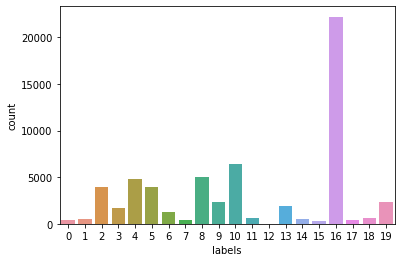

In [11]:
# Let's have a look at the class balance.
sns.countplot(train.label)
plt.xlabel('labels');

In [12]:
# split train dataset into train, validation sets
train, val= train_test_split(train,random_state=80600, test_size=0.2,shuffle =True, stratify=train['label'])

In [13]:
#many data augmentation have been tried. The issue with the augmentation was the nature of the texts. The vacabulary used is too specific so the translation or the word substitution loose this specificty.
#a better solution would have been to use more data from Arxiv articles.

train = TextAugmTranslate(train,12,5) # label 12 example multi by 2**5
train = TextAugmTranslate(train,0,2) # label 0 example multi by 2**2
train = TextAugmTranslate(train,1,1) # label 1 example multi by 2**2  # best *1
#train = TextAugmTranslate(train,7,2) # label 7 example multi by 2**2
#train = TextAugmTranslate(train,11,2) # label 11 example multi by 2**2

#train = TextAugmTranslate(train,12,3) # label 12 example multi by 2**2
#train = TextAugmTranslate(train,14,3) # label 14 example multi by 2**2
#train = TextAugmTranslate(train,15,3) # label 15 example multi by 2**2
#train = TextAugmTranslate(train,18,3) # label 18 example multi by 2**2

#train = TextAugmTranslate(train,17,2) # label 17 example multi by 2**2

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/501M [00:00<?, ?B/s]

iter 0 | init shape : (18, 3) of label 12 | start time Thu Apr 29 19:04:17 2021
new shape : (36, 3) of label 12 | end time Thu Apr 29 19:04:20 2021
iter 1 | init shape : (36, 3) of label 12 | start time Thu Apr 29 19:04:20 2021
new shape : (72, 3) of label 12 | end time Thu Apr 29 19:04:26 2021
iter 2 | init shape : (72, 3) of label 12 | start time Thu Apr 29 19:04:26 2021
new shape : (144, 3) of label 12 | end time Thu Apr 29 19:04:39 2021
iter 3 | init shape : (144, 3) of label 12 | start time Thu Apr 29 19:04:39 2021
new shape : (288, 3) of label 12 | end time Thu Apr 29 19:05:05 2021
iter 4 | init shape : (288, 3) of label 12 | start time Thu Apr 29 19:05:05 2021
new shape : (576, 3) of label 12 | end time Thu Apr 29 19:05:56 2021
iter 0 | init shape : (364, 3) of label 0 | start time Thu Apr 29 19:05:56 2021
new shape : (728, 3) of label 0 | end time Thu Apr 29 19:07:16 2021
iter 1 | init shape : (728, 3) of label 0 | start time Thu Apr 29 19:07:16 2021
new shape : (1456, 3) of la

In [14]:
#tried but decrease the accuracy

#train_16 = train.loc[train.loc[:,"label"]==16].sample(n=10000)
#train= pd.concat([train[train['label']!=16],train_16], axis=0).sample(frac=1).reset_index(drop=True)

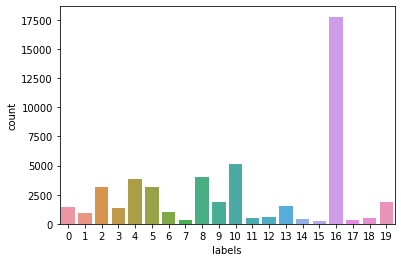

In [15]:
# Let's have a look at the class balance.
sns.countplot(train.label)
plt.xlabel('labels');

In [16]:
#concat title and abstract
train['LongSentence'] = train['title'] + " " + train['abstract']
val['LongSentence'] = val['title'] + " " + val['abstract']
test['LongSentence'] = test['title'] + " " + test['abstract']

In [17]:
# Save preprocessed data,
train.to_csv(f"{output_path}prep_train_aug.csv")
val.to_csv(f"{output_path}prep_val.csv")
test.to_csv(f"{output_path}prep_test.csv")

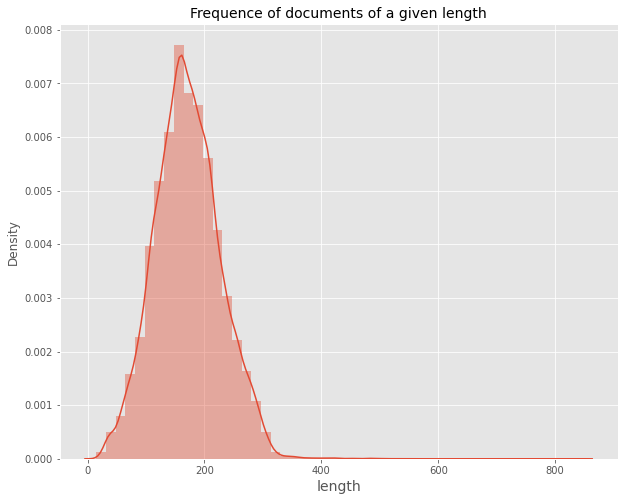

In [18]:
# Plot histogram with the length. Truncate max length to 5000 tokens.
plt.style.use("ggplot")

plt.figure(figsize=(10, 8))
train['length'] = train['LongSentence'].apply(lambda x: len(x.split()))
sns.distplot(train['length'])
plt.title('Frequence of documents of a given length', fontsize=14)
plt.xlabel('length', fontsize=14)
None

In [19]:
# Set random seed and set device to GPU.
torch.manual_seed(17)

if torch.cuda.is_available():
    device = torch.device('cuda')
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
else:
    device = torch.device('cpu')

print(device)

cuda


In [20]:
#use SciBERT. a BERT trained on scientific papers
do_lower_case = True

MODEL_NAME = 'allenai/scibert_scivocab_uncased'
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME, do_lower_case=do_lower_case) #

Downloading:   0%|          | 0.00/228k [00:00<?, ?B/s]

In [21]:
# Set tokenizer hyperparameters.
MAX_SEQ_LEN = 512
BATCH_SIZE = 16
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)


# Define columns to read.
label_field = Field(sequential=False, use_vocab=False, batch_first=True)
text_field = Field(use_vocab=False, 
                   tokenize=tokenizer.encode, 
                   include_lengths=False, 
                   batch_first=True,
                   fix_length=MAX_SEQ_LEN, 
                   pad_token=PAD_INDEX, 
                   unk_token=UNK_INDEX)

fields = {'LongSentence' : ('LongSentence', text_field), 'label' : ('label', label_field)}


# Read preprocessed CSV into TabularDataset and split it into train, test and valid.
train_data = TabularDataset(path=f"{output_path}/prep_train_aug.csv", 
                                                   format='CSV', 
                                                   fields=fields, 
                                                   skip_header=False)

valid_data = TabularDataset(path=f"{output_path}/prep_val.csv", 
                                                   format='CSV', 
                                                   fields=fields, 
                                                   skip_header=False)

test_data = TabularDataset(path=f"{output_path}/prep_test.csv", 
                                                   format='CSV', 
                                                   fields=fields, 
                                                   skip_header=False)

# Create train and validation iterators.
train_iter, valid_iter = BucketIterator.splits((train_data, valid_data),
                                               batch_size=BATCH_SIZE,
                                               device=device,
                                               shuffle=True,
                                               sort_key=lambda x: len(x.LongSentence), 
                                               sort=True, 
                                               sort_within_batch=False)

# Test iterator, no shuffling or sorting required.
test_iter = Iterator(test_data, batch_size=BATCH_SIZE, device=device, train=False, shuffle=False, sort=False)

In [22]:
# Functions for saving and loading model parameters and metrics.
def save_checkpoint(path, model, valid_loss):
    torch.save({'model_state_dict': model.state_dict(),
                  'valid_loss': valid_loss}, path)

    
def load_checkpoint(path, model):    
    state_dict = torch.load(path, map_location=device)
    model.load_state_dict(state_dict['model_state_dict'])
    
    return state_dict['valid_loss']


def save_metrics(path, train_loss_list, valid_loss_list, global_steps_list):   
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, path)


def load_metrics(path):    
    state_dict = torch.load(path, map_location=device)
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

In [23]:
# Model with extra layers on top of SciBERT
class SciBERTClassifier(torch.nn.Module):
    def __init__(self, dropout_rate=0.3):
        super(SciBERTClassifier, self).__init__()
        
        self.SciBERT = BertModel.from_pretrained('allenai/scibert_scivocab_uncased')
        self.d1 = torch.nn.Dropout(dropout_rate)
        self.l1 = torch.nn.Linear(768, 64)
        self.bn1 = torch.nn.LayerNorm(64)
        self.d2 = torch.nn.Dropout(dropout_rate)
        self.l2 = torch.nn.Linear(64, 20)
        
    def forward(self, input_ids, attention_mask):
        x = self.SciBERT(input_ids=input_ids, attention_mask=attention_mask)
        x = x[1]
        x = self.d1(x)
        x = self.l1(x)
        x = self.bn1(x)
        x = torch.nn.Tanh()(x)
        x = self.d2(x)
        x = self.l2(x)
        #print(x.shape)
        return x

In [24]:
def pretrain(model, 
             optimizer, 
             train_iter, 
             valid_iter, 
             scheduler = None,
             valid_period = len(train_iter),
             num_epochs = 5):
    
    # Pretrain linear layers, do not train bert
    for param in model.SciBERT.parameters():
        param.requires_grad = False
    
    model.train()
    
    # Initialize losses and loss histories
    train_loss = 0.0
    valid_loss = 0.0 

    global_step = 0  
    
    # Train loop
    for epoch in range(num_epochs):
        for (source, target), _ in train_iter:
            mask = (source != PAD_INDEX).type(torch.uint8)
            
            logits = model(input_ids=source,  
                           attention_mask=mask)
            y_pred = torch.max(logits, dim=-1)[1]
            loss = torch.nn.CrossEntropyLoss()(logits, target)
            loss.backward()
            
            # Optimizer and scheduler step
            optimizer.step()    
            scheduler.step()
                
            optimizer.zero_grad()
            
            # Update train loss and global step
            train_loss += loss.item()
            global_step += 1
            
            # Validation loop. Save progress and evaluate model performance.
            if global_step % valid_period == 0:
                model.eval()
                
                with torch.no_grad():                    
                    for (source, target), _ in valid_iter:
                        mask = (source != PAD_INDEX).type(torch.uint8)
                        
                        logits = model(input_ids=source, 
                                       attention_mask=mask)
   
                        y_pred = torch.max(logits, dim=-1)[1]

                        loss = torch.nn.CrossEntropyLoss()(logits, target)

                        valid_loss += loss.item()

                # Store train and validation loss history
                train_loss = train_loss / valid_period
                valid_loss = valid_loss / len(valid_iter)
                model.train()

                # print summary
                print('Epoch [{}/{}], global step [{}/{}], PreTrain Loss: {:.4f}, Val Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_iter),
                              train_loss, valid_loss))
                
                train_loss = 0.0                
                valid_loss = 0.0
    
    # Set Scibert parameters back to trainable
    for param in model.SciBERT.parameters():
        param.requires_grad = True
       
    print('Pre-training done!')

In [25]:
# Training Function

def train(model,
          optimizer,
          train_iter,
          valid_iter,
          scheduler = None,
          num_epochs = 5,
          valid_period = len(train_iter),
          output_path = output_path):
    
    # Initialize losses and loss histories
    train_loss = 0.0
    valid_loss = 0.0

    train_loss_list = []
    valid_loss_list = []

    best_valid_loss = float('Inf')
    
    global_step = 0
    global_steps_list = []
    
    model.train()
    
    # Train loop
    for epoch in range(num_epochs):
        for (source, target), _ in train_iter:
            mask = (source != PAD_INDEX).type(torch.uint8)

            logits = model(input_ids=source,  
                           attention_mask=mask)

            y_pred = torch.max(logits, dim=-1)[1]                   
            
            loss = torch.nn.CrossEntropyLoss()(logits, target)
            
            loss.backward()
            
            # Optimizer and scheduler step
            optimizer.step()    
            scheduler.step()
                
            optimizer.zero_grad()

            # Update train loss and global step
            train_loss += loss.item()
            global_step += 1

            # Validation loop. Save progress and evaluate model performance.
            if global_step % valid_period == 0:
                model.eval()
                
                with torch.no_grad():                    
                    for (source, target), _ in valid_iter:
                        mask = (source != PAD_INDEX).type(torch.uint8)

                        logits = model(input_ids=source, 
                                       attention_mask=mask)
                           
                        y_pred = torch.max(logits, dim=-1)[1]

                        loss = torch.nn.CrossEntropyLoss()(logits, target)         
                        valid_loss += loss.item()

                # Store train and validation loss history
                train_loss = train_loss / valid_period
                valid_loss = valid_loss / len(valid_iter)
                train_loss_list.append(train_loss)
                valid_loss_list.append(valid_loss)
                global_steps_list.append(global_step)

                # print summary
                print('Epoch [{}/{}], global step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_iter),
                              train_loss, valid_loss))
                
                # checkpoint
                if best_valid_loss > valid_loss:
                    best_valid_loss = valid_loss
                    save_checkpoint(output_path + 'model.pkl', model, best_valid_loss)
                    save_metrics(output_path + 'metric.pkl', train_loss_list, valid_loss_list, global_steps_list)
                        
                train_loss = 0.0                
                valid_loss = 0.0

                model.train()

    save_metrics(output_path + 'metric.pkl', train_loss_list, valid_loss_list, global_steps_list)
    print('Training done!')

In [26]:
# Main training loop
NUM_EPOCHS = 6

steps_per_epoch = len(train_iter)

model = SciBERTClassifier(0.4)
model = model.to(device)


optimizer = AdamW(model.parameters(), lr=1e-4)
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=steps_per_epoch*1, 
                                            num_training_steps=steps_per_epoch*NUM_EPOCHS)

print("======================= Start pretraining ==============================")

pretrain(model=model,
         train_iter=train_iter,
         valid_iter=valid_iter,
         optimizer=optimizer,
         scheduler=scheduler,
         num_epochs=NUM_EPOCHS)

NUM_EPOCHS = 6 #15
print("======================= Start training =================================")
optimizer = AdamW(model.parameters(), lr=2e-6) #2e-6
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=steps_per_epoch*2, 
                                            num_training_steps=steps_per_epoch*NUM_EPOCHS)

train(model=model, 
      train_iter=train_iter, 
      valid_iter=valid_iter, 
      optimizer=optimizer, 
      scheduler=scheduler, 
      num_epochs=NUM_EPOCHS)

Downloading:   0%|          | 0.00/385 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/442M [00:00<?, ?B/s]

======================= Start pretraining ==============================
Epoch [1/6], global step [3132/18792], PreTrain Loss: 2.2122, Val Loss: 1.8774
Epoch [2/6], global step [6264/18792], PreTrain Loss: 1.7022, Val Loss: 1.4936
Epoch [3/6], global step [9396/18792], PreTrain Loss: 1.5492, Val Loss: 1.3737
Epoch [4/6], global step [12528/18792], PreTrain Loss: 1.4859, Val Loss: 1.2710
Epoch [5/6], global step [15660/18792], PreTrain Loss: 1.4561, Val Loss: 1.1900
Epoch [6/6], global step [18792/18792], PreTrain Loss: 1.4458, Val Loss: 1.1101
Pre-training done!
======================= Start training =================================
Epoch [1/6], global step [3132/18792], Train Loss: 1.0511, Valid Loss: 0.7242
Epoch [2/6], global step [6264/18792], Train Loss: 0.7912, Valid Loss: 0.6329
Epoch [3/6], global step [9396/18792], Train Loss: 0.6934, Valid Loss: 0.5911
Epoch [4/6], global step [12528/18792], Train Loss: 0.6283, Valid Loss: 0.5723
Epoch [5/6], global step [15660/18792], Train

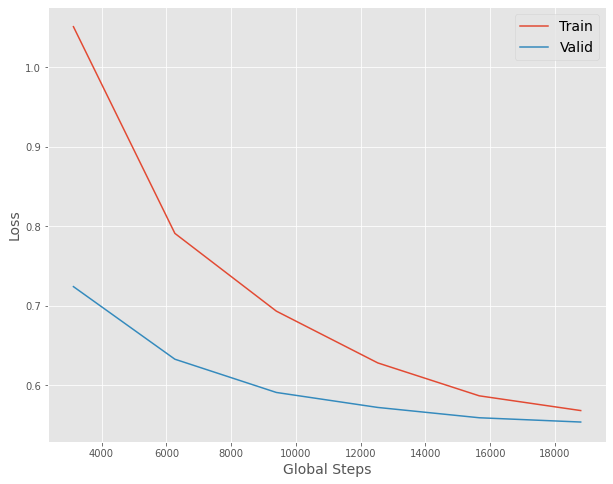

In [27]:
plt.figure(figsize=(10, 8))
train_loss_list, valid_loss_list, global_steps_list = load_metrics(output_path + 'metric.pkl')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=14)
plt.show()

In [28]:
# Evaluation Function

def evaluate(model, val_loader):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for (source, target), _ in val_loader:
                mask = (source != PAD_INDEX).type(torch.uint8)
                
                output = model(source, attention_mask=mask)

                preds= torch.max(output, axis=-1)[1]
                y_pred += preds.tolist()
                y_true += target.tolist()
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=range(20), digits=4))

    plt.figure(figsize=(15, 15))    
    cm = confusion_matrix(y_true, y_pred, labels=range(20))
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap="YlGnBu", fmt="d")
    ax.set_title('Confusion Matrix')
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    ax.xaxis.set_ticklabels(range(20))
    ax.yaxis.set_ticklabels(range(20))

Classification Report:
              precision    recall  f1-score   support

           0     0.4962    0.7253    0.5893        91
           1     0.6393    0.3482    0.4509       112
           2     0.8456    0.8712    0.8582       792
           3     0.6564    0.6388    0.6475       335
           4     0.8124    0.8759    0.8430       959
           5     0.7919    0.8275    0.8093       800
           6     0.5927    0.6221    0.6071       262
           7     0.0000    0.0000    0.0000        92
           8     0.8596    0.8885    0.8738      1013
           9     0.8640    0.8510    0.8575       463
          10     0.7643    0.8146    0.7886      1278
          11     0.0000    0.0000    0.0000       124
          12     0.2857    0.4000    0.3333         5
          13     0.7402    0.6830    0.7105       388
          14     0.8413    0.5354    0.6543        99
          15     0.9200    0.3433    0.5000        67
          16     0.9440    0.9669    0.9553      4444
    

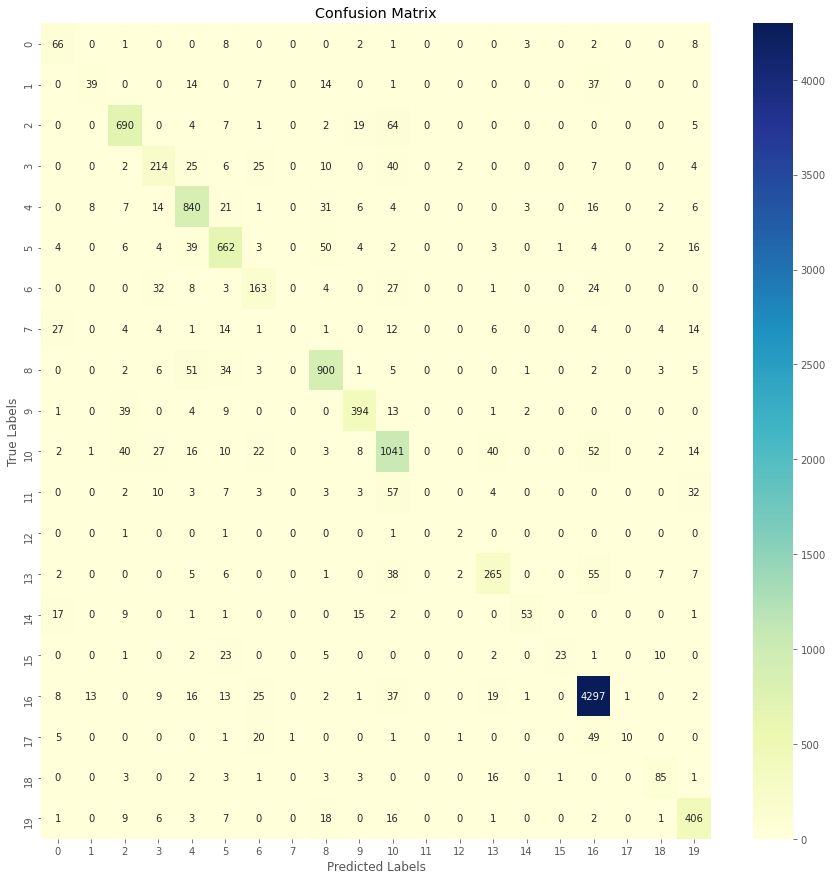

In [29]:
model = SciBERTClassifier()
model = model.to(device)

load_checkpoint(output_path + 'model.pkl', model)

evaluate(model, valid_iter)

In [30]:
test = pd.read_csv(f"{output_path}prep_test.csv")

In [31]:
#Submission function
def get_submission(model, test_loader, test_ids):
    all_preds=[]
    model.eval()
    with torch.no_grad():
      for (source, target), _ in test_loader:
                mask = (source != PAD_INDEX).type(torch.uint8)
                
                output = model(source, attention_mask=mask)
                preds= torch.max(output, axis=-1)[1]
                all_preds += preds.tolist()
                #print(len(all_preds))
    #test dataframe with prediction()
    df= pd.DataFrame({
        "id" : test_ids.values,
        "label" : np.array(all_preds)
    })
    
    df.to_csv(f"submission.csv",index=False)

In [32]:
get_submission(model,test_iter, test['node idx'])